<a href="https://colab.research.google.com/github/lilfetz22/Health_Scores_CAP2/blob/master/scripts/Health_Scores_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Health Scores Machine Learning

How healthy is your city? This notebook goes through the process of determining how your city ranks among the top 500 cities in the United States. The data that is brought in this notebook were manipulated in Health_scores_EDA jupyter notebook. The data did not come with any labels for classification; thus, this notebook uses several classification methods to then complete the classification models. This notebook begins by using the following clusterization techniques: 


1.   KMeans
2.   Decision Tree
3.   Optics
4.   Hierarchical Clustering
5.   HBDSCAN
6.   Affinity Propagation

Next the data was classified using classification models predicting the clusters. The following models were used during classification:



1.   Logistic Regression
2.   Decision Tree
3.   Random Forest
4.   LightGBM
5.   XGBoost


The models were then compared with each classification method and clusterization labels. The best combination appeared to be using ________ classification and __________ clustering. 

Finally, each location was given a rank for each feature. The feature importances found from the classification model were used to weight the features producing a score for each feature in each location. The location was scored based upon all features and given an **Overall Health Score** 







In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
import seaborn as sns
import warnings
import io
import lightgbm as lgb
import xgboost as xgb
import re
import hdbscan
from random import seed, randint,sample
from sklearn.cluster import OPTICS,KMeans,AgglomerativeClustering,AffinityPropagation
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, silhouette_samples, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
# from google.colab import files

city_data_scaled = pd.read_csv('../data/manipulated_data/city_data_scaled.csv')
tract_data_scaled = pd.read_csv('../data/manipulated_data/tract_data_scaled.csv')
city_data_manip = pd.read_csv('../data/manipulated_data/city_data_manip.csv')
tract_data_manip = pd.read_csv('../data/manipulated_data/tract_data_manip.csv')
leri_city = pd.read_csv('../data/manipulated_data/leri_city.csv')
leri_tract = pd.read_csv('../data/manipulated_data/leri_tract.csv')

In [7]:
# needed for colab not on local computer
# uploaded = files.upload()

In [8]:
# needed for colab not on local computer
# city_data_scaled = pd.read_csv(io.BytesIO(uploaded['city_data_scaled.csv']))
# tract_data_scaled = pd.read_csv(io.BytesIO(uploaded['tract_data_scaled.csv']))
city_data_scaled = city_data_scaled.set_index('stpl_fips')
tract_data_scaled = tract_data_scaled.set_index('stcotr_fips')

In [9]:
# needed for colab not on local computer
# city_data_manip = pd.read_csv(io.BytesIO(uploaded['city_data_manip.csv']))
# tract_data_manip = pd.read_csv(io.BytesIO(uploaded['tract_data_manip.csv']))
city_data_manip = city_data_manip.set_index('stpl_fips')
tract_data_manip = tract_data_manip.set_index('stcotr_fips')

In [10]:
# needed for colab not on local computer
# leri_city = pd.read_csv(io.BytesIO(uploaded['leri_city.csv']))
# leri_tract = pd.read_csv(io.BytesIO(uploaded['leri_tract.csv']))
leri_city = leri_city.set_index('stpl_fips')
leri_tract = leri_tract.set_index('stcotr_fips')

## Clustering

### KMeans

100%|████████████████████████████████████████████| 9/9 [00:01<00:00,  6.26it/s]


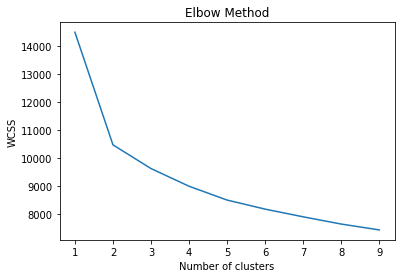

In [11]:
# Elbow Method
wcss = []
for i in tqdm(range(1, 10)):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(city_data_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [12]:
def silhouette_analysis_fx(df):
    ''' this creates a silhouette analysis for KMeans. This function was borrowed 
    from https://imaddabbura.github.io/post/kmeans-clustering/. 

    args: 
      df - dataframe to use in KMeans classification
    '''
    for i, k in enumerate([2, 3, 4, 5, 6]):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # Run the Kmeans algorithm
        km = KMeans(n_clusters=k)
        labels_cluster = km.fit_predict(df)
        centroids = km.cluster_centers_

      # Get silhouette samples
        silhouette_vals = silhouette_samples(df, labels_cluster)

      # Silhouette plot
        y_ticks = []
        y_lower, y_upper = 0, 0
        for i, cluster in enumerate(np.unique(labels_cluster)):
            cluster_silhouette_vals = silhouette_vals[labels_cluster == cluster]
            cluster_silhouette_vals.sort()
            y_upper += len(cluster_silhouette_vals)
            ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
            ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
            y_lower += len(cluster_silhouette_vals)

      # Get the average silhouette score and plot it
        avg_score = np.mean(silhouette_vals)
        print(avg_score)
        ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
        ax1.set_yticks([])
        ax1.set_xlim([-0.1, 0.5])
        ax1.set_xlabel('Silhouette coefficient values')
        ax1.set_ylabel('Cluster labels')
        ax1.set_title('Silhouette plot for the various clusters', y=1.02);

      # Scatter plot of data colored with labels
        ax2.scatter(df.iloc[:, 0], df.iloc[:, 1], c=labels_cluster)
        ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
        ax2.set_xlim([-2, 2])
        ax2.set_xlim([-2, 2])
        ax2.set_xlabel('Eruption time in mins')
        ax2.set_ylabel('Waiting time to next eruption')
        ax2.set_title('Visualization of clustered data', y=1.02)
        ax2.set_aspect('equal')
        plt.tight_layout()
        plt.suptitle(f'Silhouette analysis using k = {k}',
                  fontsize=16, fontweight='semibold', y=1.05);

0.2308296842263309
0.13158451159256843
0.11935030384425932
0.12239862596621201
0.1179326063801494


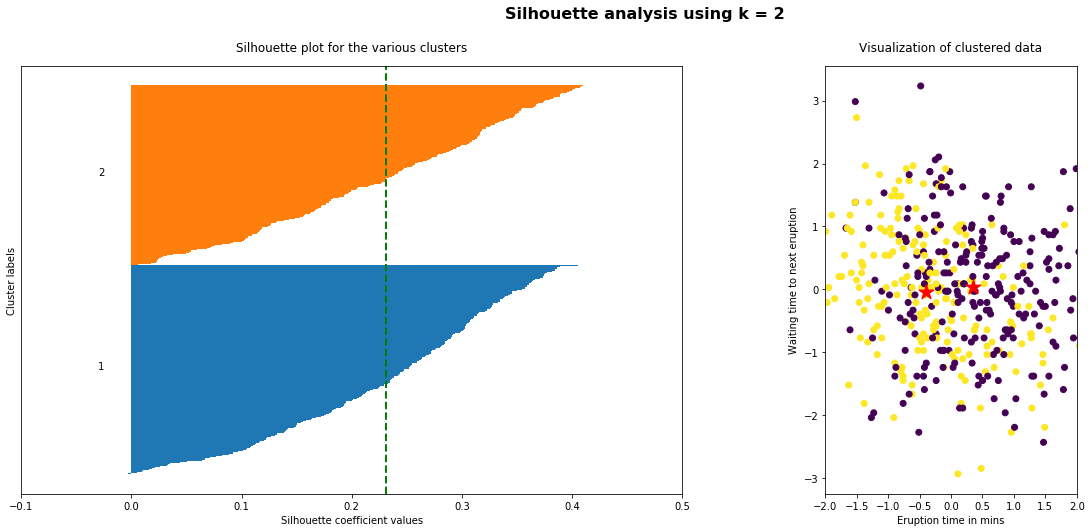

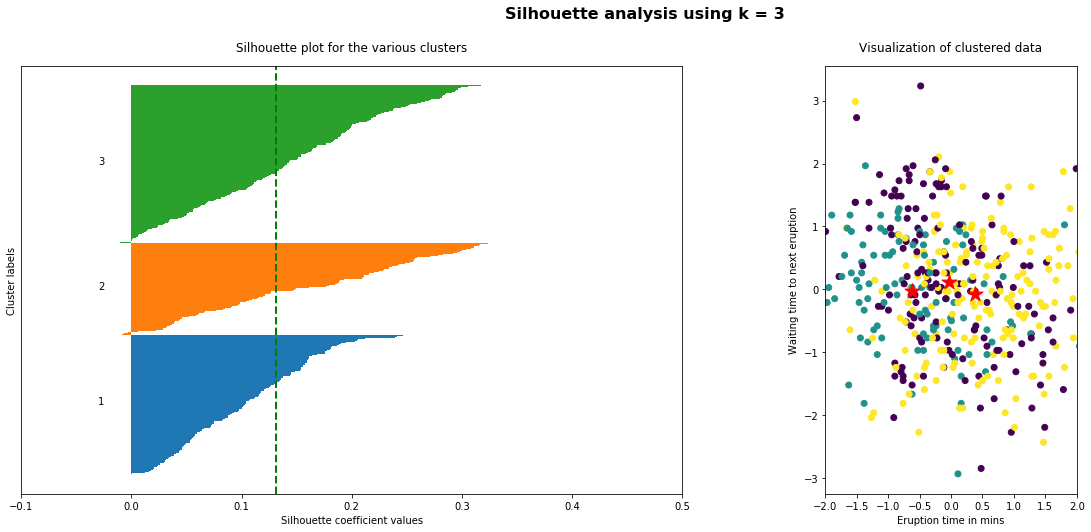

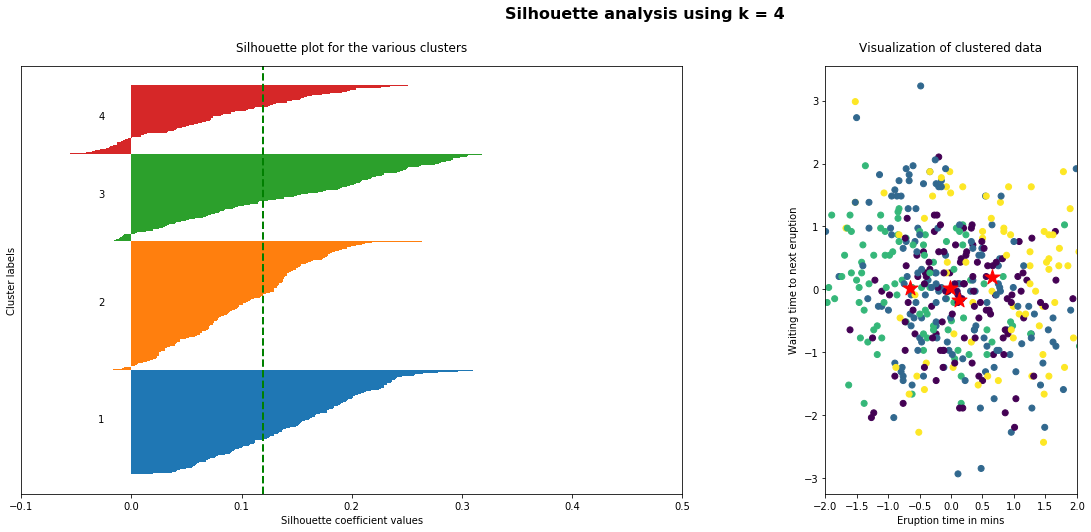

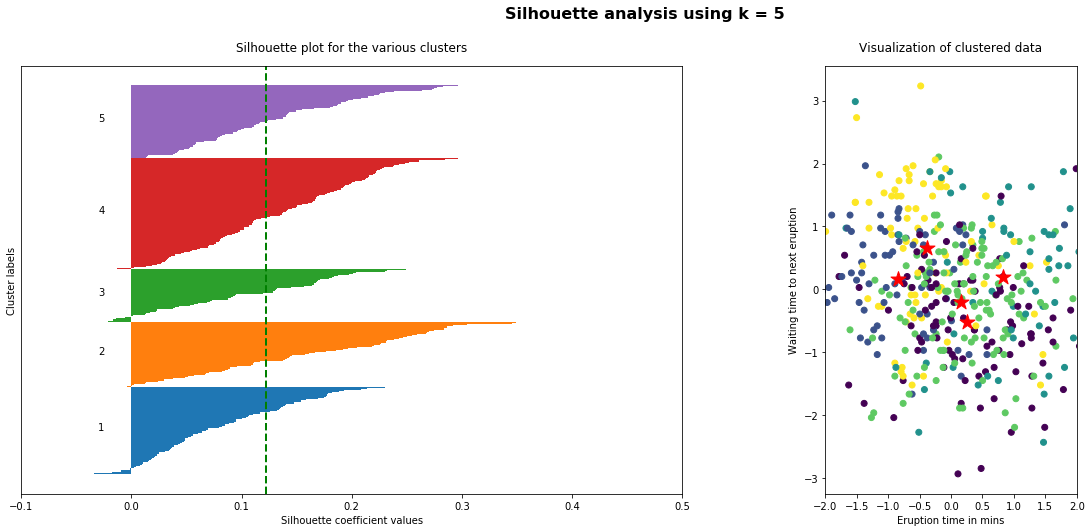

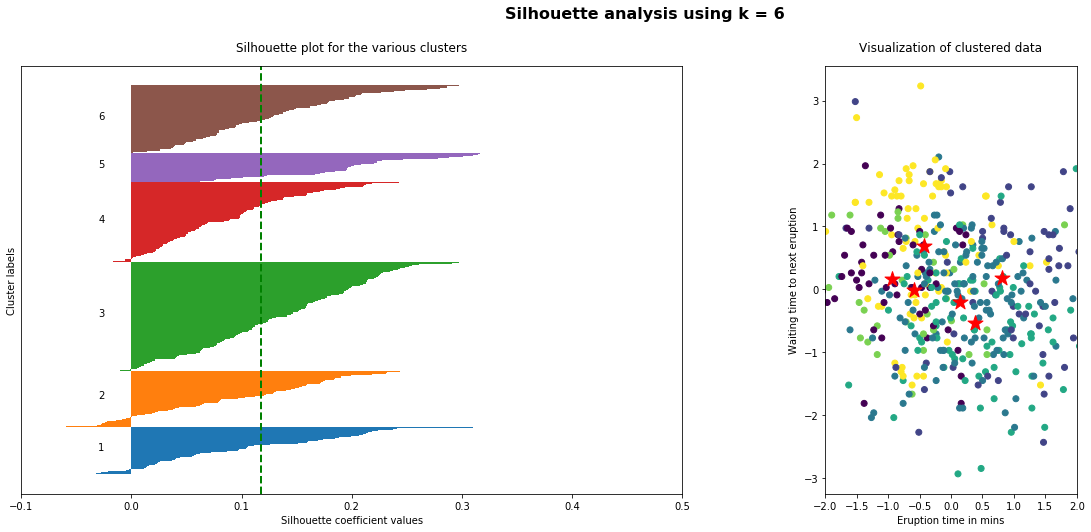

In [13]:
silhouette_analysis_fx(city_data_scaled)

0.21398854501489364
0.2286958233440338
0.23514394521735327
0.18745740398134178
0.17742626910530182


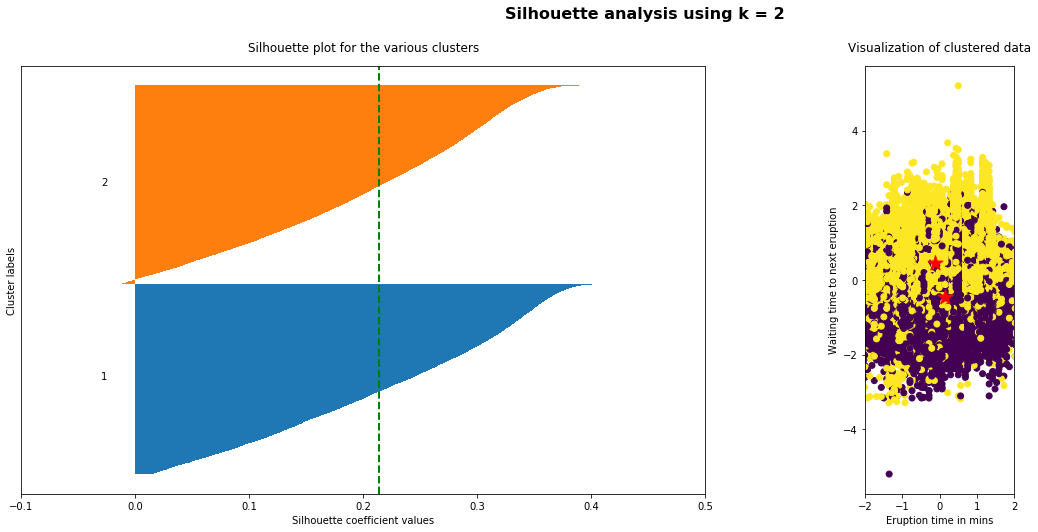

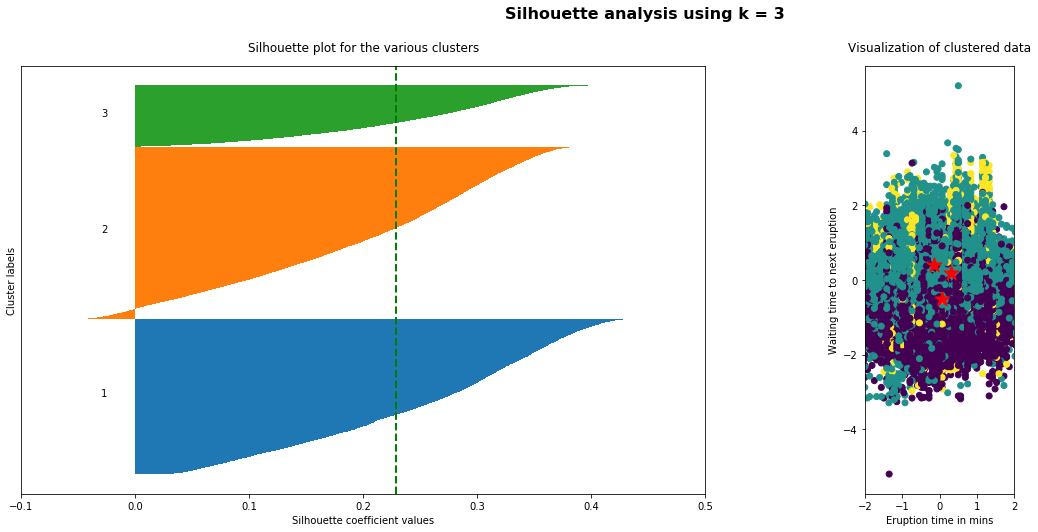

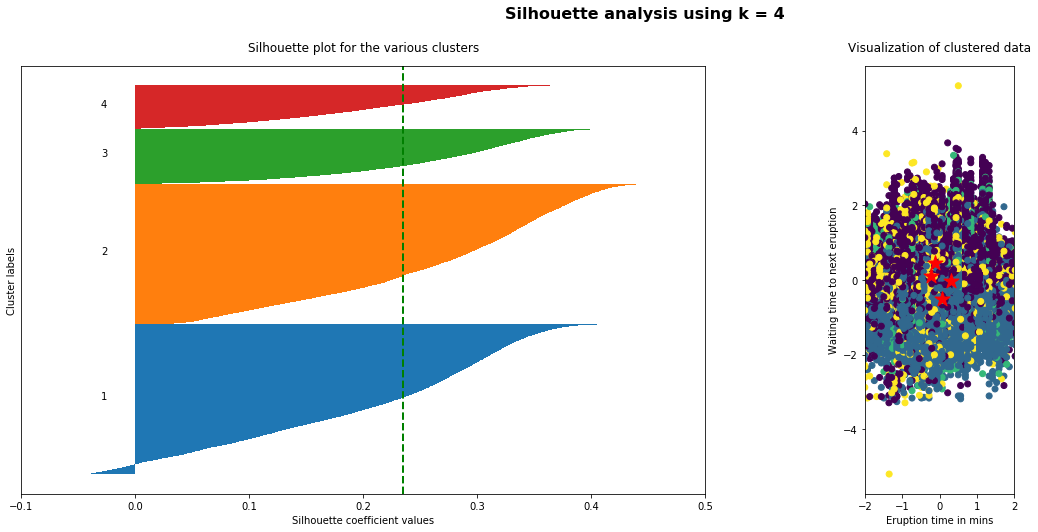

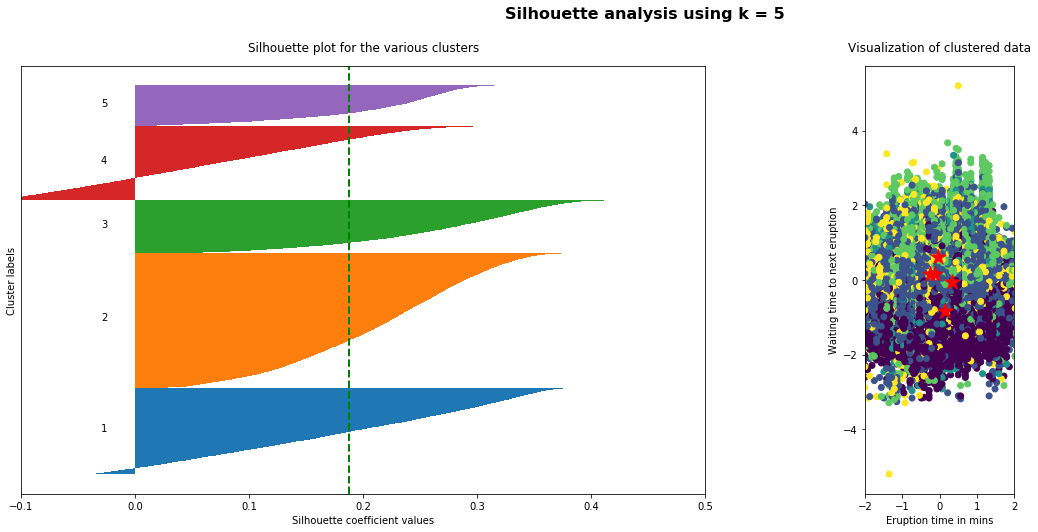

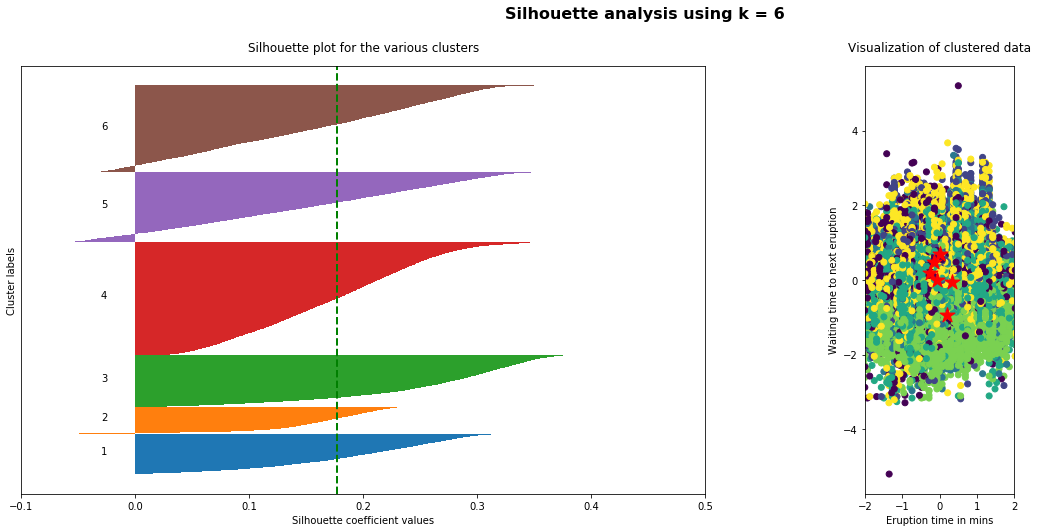

In [14]:
silhouette_analysis_fx(tract_data_scaled)

In [15]:
# based on the elbow and silhouette methods, the best number of clusters 
# appears to be 2. 
kmeans2 = KMeans(n_clusters=2, init='k-means++')
kmeans2.fit(city_data_scaled)
pred = kmeans2.predict(city_data_scaled)
frame=city_data_scaled.copy()
frame['cluster'] = pred
frame['cluster'].value_counts()

0    237
1    204
Name: cluster, dtype: int64

The following two cells just takes a closer look at this clusterization between the two clusters. I wanted to see how they compared when just looking at a few variables. Thus, the pairplot does a good job at comparing them with scatterplots and with the color corresponding to the classification label. 

In [16]:
cancer = frame.loc[:, ['cluster','Breast cancer deaths','Cardiovascular disease deaths',
                       'Colorectal cancer deaths','Diabetes']]

C:\Users\Billy\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Billy\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


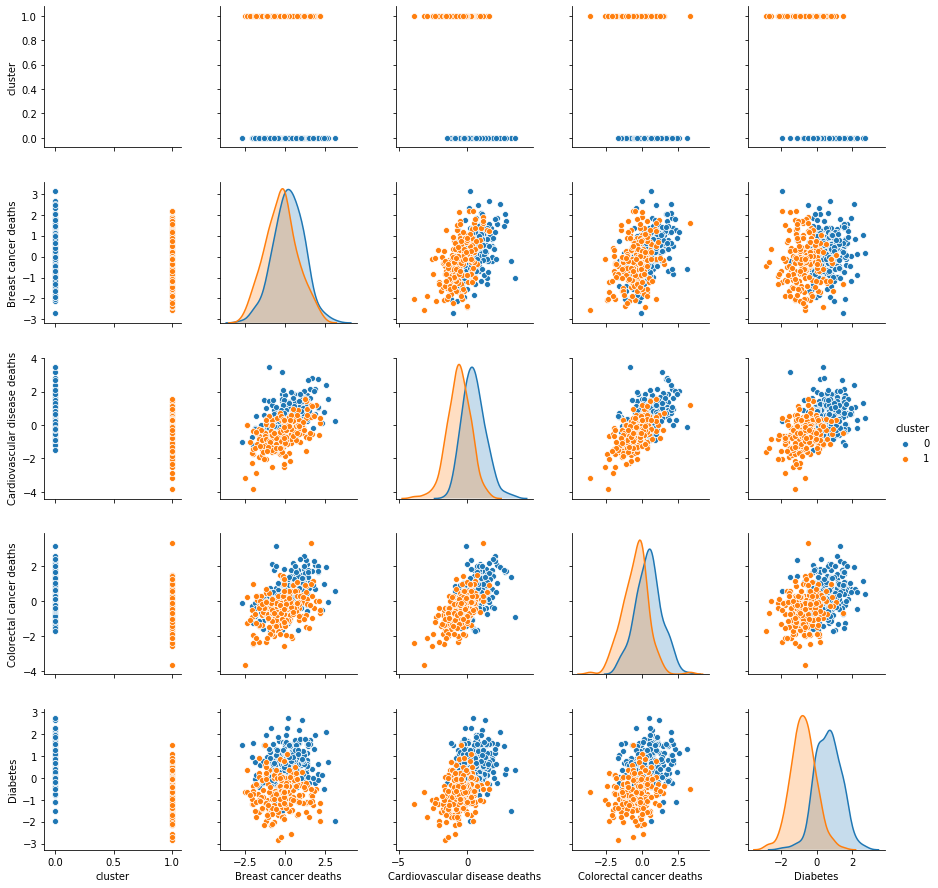

In [17]:
sns.pairplot(cancer, hue='cluster')

100%|████████████████████████████████████████████| 9/9 [00:26<00:00,  3.82s/it]


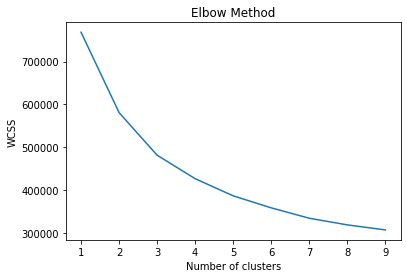

In [18]:
# Elbow method for KMeans
wcss2 = []
for i in tqdm(range(1, 10)):
    kmeans2 = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans2.fit(tract_data_scaled)
    wcss2.append(kmeans2.inertia_)
plt.plot(range(1,10), wcss2)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [19]:
# based on the elbow and silhouette methods, the best number of clusters 
# appears to be 4. 
kmeans3 = KMeans(n_clusters=4, init='k-means++')
kmeans3.fit(tract_data_scaled)
pred2 = kmeans3.predict(tract_data_scaled)
frame2=tract_data_scaled.copy()
frame2['cluster'] = pred2
frame2['cluster'].value_counts()

1    10327
0     9741
3     3743
2     3037
Name: cluster, dtype: int64

### OPTICS

In [20]:
#converting dataframes into arrays
city_arr = np.array(city_data_scaled)
tract_arr = np.array(tract_data_scaled)

In [21]:
def optics_fx(arr):
    ''' this function uses OPTICS to attempt to cluster the data.
    args:
    - arr - an array of the data (must be an array not a dataframe)
    returns:
    the labels of the clusterization model
  '''
    plt.figure(figsize=(10, 7))
    optics = OPTICS()
    opt_clust = optics.fit(arr)
    # OPTICS
    colors = ['g.', 'r.', 'b.', 'y.', 'c.']
    for klass, color in zip(range(0, 5), colors):
        Xk = arr[opt_clust.labels_ == klass]
        plt.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.6)
    plt.plot(arr[opt_clust.labels_ == -1, 0], arr[opt_clust.labels_ == -1, 1], 'k+', alpha=0.1)
    plt.title('Automatic Clustering\nOPTICS')
    plt.show()
    return opt_clust.labels_

In [22]:
optic_city = city_data_scaled.copy()
optic_tract = tract_data_scaled.copy()

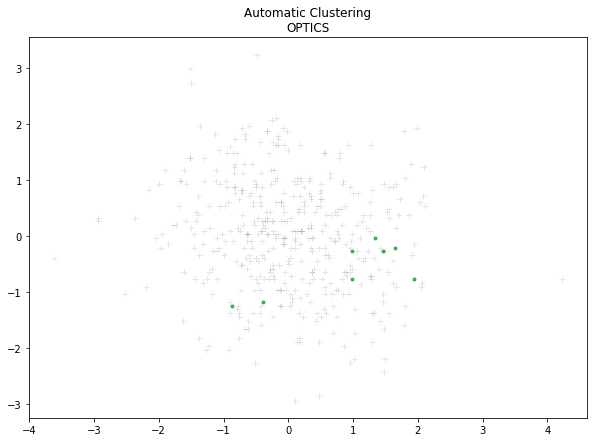

In [23]:
optic_city['optic_cluster'] = optics_fx(city_arr)

most of the datapoints the model classifies as noise, with only a few actually being labeled

In [ ]:
optic_tract['optic_cluster'] = optics_fx(tract_arr)

### **HDBSCAN**

In [ ]:
def hdbs_fx(arr):
    ''' this function uses HDBSCAN to attempt to cluster the data. cluster size is
    rather small. 
    args:
    - arr - an array of the data (must be an array not a dataframe)
    returns:
    the labels of the clusterization model
    '''
    hdbsc = hdbscan.HDBSCAN(min_cluster_size=4)
    hdbsc.fit_predict(arr)
    pal = sns.color_palette('deep', 170)
    labs = hdbsc.labels_
    colors = [sns.desaturate(pal[col], sat) for col, sat in zip(hdbsc.labels_, hdbsc.probabilities_)]
    plt.scatter(arr.T[0], arr.T[1], c=colors)
    return hdbsc.labels_

In [ ]:
hdbs_city = city_data_scaled.copy()
hdbs_tract = tract_data_scaled.copy()

In [ ]:
hdbs_city['hdbs_labels'] = hdbs_fx(city_arr)

In [ ]:
hdbs_tract['hdbs_labels'] = hdbs_fx(tract_arr)

There is a lot of noise in this dataset, the data is basically all on top of one another

### Hierarchical Clustering

In [ ]:
# Takes a while to run, might just want to look at the result that is saved in 
# pics_for_ppt folder rather than run it again. 
# plt.figure(figsize=(10,7))
# dend = shc.dendrogram(shc.linkage(city_data_scaled, method='ward'))

I have counted about 7 clusters

In [ ]:
# Takes a while to run, might just want to look at the result that is saved in 
# pics_for_ppt folder rather than run it again. 
# plt.figure(figsize=(10,7))
# dend2 = shc.dendrogram(shc.linkage(tract_data_scaled, method='ward'))

I have counted about 5 clusters

In [ ]:
cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean',linkage='ward')
agg_pred = cluster.fit_predict(city_data_scaled)
cds_copy = city_data_scaled.copy()
cds_copy['agg_predicted'] = agg_pred

In [ ]:
cluster_t = AgglomerativeClustering(n_clusters=5, affinity='euclidean',linkage='ward')
agg_pred_t = cluster_t.fit_predict(tract_data_scaled)
tds_copy = tract_data_scaled.copy()
tds_copy['agg_predicted'] = agg_pred_t

In [ ]:
sequence = list(range(0,42))

In [ ]:
rand_cols = sample(sequence, 4)
rand_cols.append(42)
rand_cols

In [ ]:
sns.pairplot(cds_copy.iloc[:, rand_cols], hue='agg_predicted')

### AffinityPropagation

In [ ]:
affprop = AffinityPropagation()
affpred = affprop.fit_predict(city_data_scaled)
cds_aff = city_data_scaled.copy()
cds_aff['aff_pred']=affpred

In [ ]:
# causes the session to crash on google colab and on my computer

# affprop = AffinityPropagation()
# tds_aff = tract_data_scaled.copy()
# affpred_t = affprop.fit_predict(tract_data_scaled)
# tds_aff['aff_pred']=affpred_t

In [ ]:
zto3 = list(range(0,4))
zto3.append(42)

In [ ]:
sns.pairplot(cds_aff.iloc[:, zto3],hue='aff_pred')

# Classification

In [ ]:
# this is a blank dataframe that will collect all of the scores from each of the models under each classification metric
model_comparison_df = pd.DataFrame()

#### Logistic Regression

In [ ]:
# scoring classification models
def cv_score(clf, x, y, score_func=accuracy_score):
    '''This is a custom metric for scoring models. 

    args: 
      clf - classification model
      x - independent variables
      y - response variable
      score_func - type of scoring metric to use on data
    returns: the average score for the model

    '''
    result=0
    nfold=5
    for train, test in KFold(nfold).split(x):
        clf.fit(x[train],y[train])
        result += score_func(clf.predict(x[test]), y[test])
    return result/nfold #average

In [ ]:
# using kmeans clustering
warnings.filterwarnings('ignore')
def logreg_fx(data, data_cluster):
    ''' This function goes through the process of creating a DecisionTreeClassifier 
    model, going through a cross validation, parameter tuning, and a stratified 
    KFold cross validation for an average score using accuracy score metric

    args: 
    data - dataframe (city/tract)
    data_clusters - the copy of the dataframe with a column that has the 
    clusterization labels added on the last column the input into this argument 
    should be a pandas series of that column that contains the cluster labels

    returns: average accuracy score
    '''
    X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                      random_state=5)
    c_space = np.logspace(0.001, 0.1, 1, 10, 100)
    logreg = LogisticRegression()
    param_grid = {'C': c_space}
    logreg_cv = GridSearchCV(logreg, param_grid, cv=5) #parameter tuning
    logreg_cv.fit(X_tr, y_tr)

    print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
    print("Best score is {}".format(logreg_cv.best_score_))
    logreg_best = LogisticRegression(C=logreg_cv.best_params_['C'])
    score = cv_score(logreg_best, X_tr, y_tr)
    return score

In [ ]:
logreg_score_c_kmeans = logreg_fx(city_data_scaled, frame['cluster'])
model_comparison_df['logreg_score_c_kmeans'] = logreg_score_c_kmeans
logreg_score_t_kmeans = logreg_fx(tract_data_scaled, frame2['cluster'])
model_comparison_df['logreg_score_t_kmeans'] = logreg_score_t_kmeans

In [ ]:
logreg_score_c_agg = logreg_fx(city_data_scaled, cds_copy['agg_predicted'])
model_comparison_df['logreg_score_c_agg'] = logreg_score_c_agg
logreg_score_t_agg = logreg_fx(tract_data_scaled, tds_copy['agg_predicted'])
model_comparison_df['logreg_score_t_agg'] = logreg_score_t_agg

In [ ]:
logreg_score_c_aff = logreg_fx(city_data_scaled, cds_aff['aff_pred'])
model_comparison_df['logreg_score_c_aff'] = logreg_score_c_aff
# cannot get Affinity clustering to work on computer for tract data

In [ ]:
logreg_score_c_optic = logreg_fx(city_data_scaled, optic_city['optic_cluster'])
model_comparison_df['logreg_score_c_optic'] = logreg_score_c_optic

In [ ]:
logreg_score_t_optic = logreg_fx(tract_data_scaled, optic_tract['optic_cluster'])
model_comparison_df['logreg_score_t_optic'] = logreg_score_t_optic

In [ ]:
logreg_score_c_hdbs = logreg_fx(city_data_scaled, hdbs_city['hdbs_labels'])
model_comparison_df['logreg_score_c_hdbs'] = logreg_score_c_hdbs

In [ ]:
logreg_score_t_hdbs = logreg_fx(tract_data_scaled, hdbs_tract['hdbs_labels'])
model_comparison_df['logreg_score_t_hdbs'] = logreg_score_t_hdbs

#### Decision Tree

In [ ]:
def dt_fx(data, data_cluster):
    ''' This function goes through the process of creating a DecisionTreeClassifier 
  model, going through a cross validation, parameter tuning, and a stratified 
  KFold cross validation for an average score using accuracy score metric

            args: 
            data - dataframe (city/tract)
            data_clusters - the copy of the dataframe with a column that has the 
            clusterization labels added on the last column the input into this 
            argument should be a pandas series of that column that contains the 
            cluster labels

            returns: average accuracy score

  '''
    X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                         random_state=5)
    dt = DecisionTreeClassifier()
    dt_base_fit = dt.fit(X_tr, y_tr)
    dt_base_pred = dt_base_fit.predict(X_test)
    dt_base_score = accuracy_score(y_test, dt_base_pred)
    print("Baseline Score: {}".format(dt_base_score))
    
    md = np.linspace(1,32,32,endpoint=True)
    min_samples = np.linspace(0.1,1,10,endpoint=True)
    mleaf = np.linspace(0.1,0.5,5,endpoint=True)
    maxfeat = list(range(1,X_tr.shape[1]))
    param_grid = {'max_depth': md, 'min_samples_split': min_samples, 'min_samples_leaf': mleaf, 
                  'max_features': maxfeat}
    dt_cv = GridSearchCV(dt,param_grid, cv=5, scoring='accuracy')
    dt_cv.fit(X_tr,y_tr)
    print("Tuned Parameters: {}".format(dt_cv.best_params_)) 
    print("Best score is {}".format(dt_cv.best_score_))
    dt_best = DecisionTreeClassifier(max_depth = dt_cv.best_params_['max_depth'],
                                    min_samples_split = dt_cv.best_params_['min_samples_split'],
                                    min_samples_leaf = dt_cv.best_params_['min_samples_leaf'],
                                    max_features = dt_cv.best_params_['max_features'])
    dt_best_fit = dt_best.fit(X_tr, y_tr)
    dt_best_pred = dt_best_fit.predict(X_test)
    dt_score = accuracy_score(y_test, dt_best_pred)
    return dt_score

In [ ]:
dt_score_c_kmeans = dt_fx(city_data_scaled, frame['cluster'])
model_comparison_df['dt_score_c_kmeans'] = dt_score_c_kmeans
dt_score_t_kmeans = dt_fx(tract_data_scaled, frame2['cluster'])
model_comparison_df['dt_score_t_kmeans'] = dt_score_t_kmeans

In [ ]:
dt_score_c_agg = dt_fx(city_data_scaled, cds_copy['agg_predicted'])
model_comparison_df['dt_score_c_agg'] = dt_score_c_agg

In [ ]:
dt_score_c_aff = dt_fx(city_data_scaled, cds_aff['aff_pred'])
model_comparison_df['dt_score_c_aff'] = dt_score_c_aff

In [ ]:
dt_score_c_optic = dt_fx(city_data_scaled, optic_city['optic_cluster'])
model_comparison_df['dt_score_c_optic'] = dt_score_c_optic

In [ ]:
dt_score_t_optic = dt_fx(tract_data_scaled, optic_tract['optic_cluster'])
model_comparison_df['dt_score_t_optic'] = dt_score_t_optic

In [ ]:
dt_score_c_hdbs = dt_fx(city_data_scaled, hdbs_city['hdbs_labels'])
model_comparison_df['dt_score_c_hdbs'] = dt_score_c_hdbs

In [ ]:
dt_score_t_hdbs = dt_fx(tract_data_scaled, hdbs_tract['hdbs_labels'])
model_comparison_df['dt_score_t_hdbs'] = dt_score_t_hdbs

#### Random Forest

In [ ]:
def rf_fx(data, data_cluster):
    ''' This function goes through the process of creating a RandomForestClassifier 
    model. Model is fit to the training data and an accuracy score is printed. 

            args: 
            data - dataframe (city/tract)
            data_clusters - the copy of the dataframe with a column that has the 
            clusterization labels added on the last column the input into this 
            argument should be a pandas series of that column that contains the 
            cluster labels

            returns: dataframe of feature importances, average accuracy score

    '''
    X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                      random_state=5)
    features = list(data.columns)
    mod = RandomForestClassifier()
    mod_base_fit = mod.fit(X_tr, y_tr)
    mod_base_pred = mod_base_fit.predict(X_test)
    mod_base_score = accuracy_score(y_test, mod_base_pred)
    # print("Baseline Score: {}".format(mod_base_score))

    feature_importance = list(zip(features, mod_base_fit.feature_importances_))
    fi_df = pd.DataFrame(feature_importance, columns=['Feature','importance'])
    fi_df = fi_df.sort_values('importance', ascending=False)
    return fi_df, mod_base_score

In [ ]:
rf_result_c_kmeans = rf_fx(city_data_scaled, frame['cluster'])
model_comparison_df['rf_score_c_kmeans'] = rf_result_c_kmeans[1]
rf_result_c_kmeans[0]

In [ ]:
rf_result_t_kmeans = rf_fx(tract_data_scaled, frame2['cluster'])
model_comparison_df['rf_score_t_kmeans'] = rf_result_t_kmeans[1]
rf_result_t_kmeans[0]

In [ ]:
rf_result_c_agg = rf_fx(city_data_scaled, cds_copy['agg_predicted'])
model_comparison_df['rf_score_c_agg'] = rf_result_c_agg[1]
rf_result_c_agg[0]

In [ ]:
rf_result_t_agg = rf_fx(tract_data_scaled, tds_copy['agg_predicted'])
model_comparison_df['rf_score_t_agg'] = rf_result_t_agg[1]
rf_result_t_agg[0]

In [ ]:
rf_result_c_aff = rf_fx(city_data_scaled, cds_aff['aff_pred'])
model_comparison_df['rf_score_c_aff'] = rf_result_c_aff[1]
rf_result_c_aff[0]

In [ ]:
rf_result_c_optic = rf_fx(city_data_scaled, optic_city['optic_cluster'])
model_comparison_df['rf_score_c_optic'] = rf_result_c_optic[1]
rf_result_c_optic[0]

In [ ]:
rf_result_t_optic = rf_fx(tract_data_scaled, optic_tract['optic_cluster'])
model_comparison_df['rf_score_t_optic'] = rf_result_t_optic[1]
rf_result_t_optic[0]

In [ ]:
rf_result_c_hdbs = rf_fx(city_data_scaled, hdbs_city['hdbs_labels'])
model_comparison_df['rf_score_c_hdbs'] = rf_result_c_hdbs[1]
rf_result_c_hdbs[0]

In [ ]:
rf_result_t_hdbs = rf_fx(tract_data_scaled, hdbs_tract['hdbs_labels'])
model_comparison_df['rf_score_t_hdbs'] = rf_result_t_hdbs[1]
rf_result_t_hdbs[0]

#### Light GBM

In [ ]:
def gbm_fx(data, data_cluster):
    ''' This function creates a LGBMRanker model, best attempts were made to have 
    an evaluation metric work with this function but to no avail. 

    args: 
            data - dataframe (city/tract)
            data_clusters - the copy of the dataframe with a column that has the 
            clusterization labels added on the last column the input into this 
            argument should be a pandas series of that column that contains the 
            cluster labels

            returns: dataframe of feature importances
    '''
    X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                      random_state=5)
    features = list(data.columns)
    evaluation_dict = {}
    gbm = lgb.LGBMRanker()
    q_train = [X_tr.shape[0]]
    mod_base_fit = gbm.fit(X_tr, y_tr, group=q_train, callbacks=[lgb.record_evaluation(evaluation_dict)])
    mod_base_pred = mod_base_fit.predict(X_test)


    feature_importance = list(zip(features, mod_base_fit.feature_importances_))
    fi_df = pd.DataFrame(feature_importance, columns=['Feature','importance'])
    fi_df = fi_df.sort_values('importance', ascending=False)
    return fi_df

In [ ]:
gbm_fx(city_data_scaled, frame['cluster'])

In [ ]:
gbm_fx(tract_data_scaled, frame2['cluster'])

In [ ]:
gbm_fx(city_data_scaled, cds_copy['agg_predicted'])

In [ ]:
gbm_fx(tract_data_scaled, tds_copy['agg_predicted'])

In [ ]:
# gbm_fx(city_data_scaled, cds_aff['aff_pred'])

In [ ]:
def gbm_Class_fx(data, data_cluster):
    ''' This function goes through the process of creating a LGBMClassifier model, 
  going through a cross validation, plotting the importance of each feature, 
  and a stratified KFold cross validation for an average score using accuracy 
  score metric

  args: 
  data - dataframe (city/tract)
  data_clusters - the copy of the dataframe with a column that has the clusterization 
  labels added on the last column the input into this argument should be a pandas 
  series of that column that contains the cluster labels

  returns: dataframe of feature importances, average accuracy score, standard 
  deviation of accuracy score

    '''
    X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                      random_state=5)
    features = list(data.columns)
    gbm = lgb.LGBMClassifier()
    q_train = [X_tr.shape[0]]
    mod_base_fit = gbm.fit(X_tr, y_tr)
    mod_base_pred = mod_base_fit.predict(X_test)
    score = accuracy_score(y_test, mod_base_pred)
    print("Score: {}".format(score))
    print("Classes: {}".format(mod_base_fit.classes_))
    kfold = StratifiedKFold(n_splits=5, random_state=7)
    results = cross_val_score(gbm, data.values, data_cluster.values, cv=kfold)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

    feature_importance = list(zip(features, mod_base_fit.feature_importances_))
    fi_df = pd.DataFrame(feature_importance, columns=['Feature','importance'])
    fi_df = fi_df.sort_values('importance', ascending=False)
    return fi_df, results.mean()*100, results.std()*100

In [ ]:
gbm_result_c_kmeans = gbm_Class_fx(city_data_scaled, frame['cluster'])
model_comparison_df['gbm_score_c_kmeans'] = gbm_result_c_kmeans[1]
model_comparison_df['gbm_scorestd_c_kmeans'] = gbm_result_c_kmeans[2]
gbm_result_c_kmeans[0]

In [ ]:
gbm_result_t_kmeans = gbm_Class_fx(tract_data_scaled, frame2['cluster'])
model_comparison_df['gbm_score_t_kmeans'] = gbm_result_t_kmeans[1]
model_comparison_df['gbm_scorestd_t_kmeans'] = gbm_result_t_kmeans[2]
gbm_result_t_kmeans[0]

In [ ]:
gbm_result_c_agg = gbm_Class_fx(city_data_scaled, cds_copy['agg_predicted'])
model_comparison_df['gbm_score_c_agg'] = gbm_result_c_agg[1]
model_comparison_df['gbm_scorestd_c_agg'] = gbm_result_c_agg[2]
gbm_result_c_agg[0]

In [ ]:
gbm_result_t_agg = gbm_Class_fx(tract_data_scaled, tds_copy['agg_predicted'])
model_comparison_df['gbm_score_t_agg'] = gbm_result_t_agg[1]
model_comparison_df['gbm_scorestd_t_agg'] = gbm_result_t_agg[2]
gbm_result_t_agg[0]

In [ ]:
gbm_result_c_aff = gbm_Class_fx(city_data_scaled, cds_aff['aff_pred'])
model_comparison_df['gbm_score_c_aff'] = gbm_result_c_aff[1]
model_comparison_df['gbm_scorestd_c_aff'] = gbm_result_c_aff[2]
gbm_result_c_aff[0]

In [ ]:
gbm_result_c_optic = gbm_Class_fx(city_data_scaled, optic_city['optic_cluster'])
model_comparison_df['gbm_score_c_optic'] = gbm_result_c_optic[1]
model_comparison_df['gbm_scorestd_c_optic'] = gbm_result_c_optic[2]
gbm_result_c_optic[0]

In [ ]:
gbm_result_t_optic = gbm_Class_fx(tract_data_scaled, optic_tract['optic_cluster'])
model_comparison_df['gbm_score_t_optic'] = gbm_result_t_optic[1]
model_comparison_df['gbm_scorestd_t_optic'] = gbm_result_t_optic[2]
gbm_result_t_optic[0]

In [ ]:
gbm_result_c_hdbs = gbm_Class_fx(city_data_scaled, hdbs_city['hdbs_labels'])
model_comparison_df['gbm_score_c_hdbs'] = gbm_result_c_hdbs[1]
model_comparison_df['gbm_scorestd_c_hdbs'] = gbm_result_c_hdbs[2]
gbm_result_c_hdbs[0]

In [ ]:
gbm_result_t_hdbs = gbm_Class_fx(tract_data_scaled, hdbs_tract['hdbs_labels'])
model_comparison_df['gbm_score_t_hdbs'] = gbm_result_t_hdbs[1]
model_comparison_df['gbm_scorestd_t_hdbs'] = gbm_result_t_hdbs[2]
gbm_result_t_hdbs[0]

#### XGBoost

In [ ]:
def xgm_fx(data, data_cluster):
    ''' This function goes through the process of creating a XGBClassifier model, 
    going through a cross validation, plotting the importance of each feature, 
    and a stratified KFold cross validation for an average score using accuracy score metric

    args: 
    data - dataframe (city/tract)
    data_clusters - the copy of the dataframe with a column that has the clusterization 
    labels added on the last column the input into this argument should be a pandas 
    series of that column that contains the cluster labels

    returns: dataframe of feature importances, average accuracy score, standard 
    deviation of accuracy score

    '''
    data_dmatrix = xgb.DMatrix(data=data,label=data_cluster)
    X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                      random_state=5)
    features = list(data.columns)
    xgm = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

    mod_base_fit = xgm.fit(X_tr, y_tr)
    mod_base_pred = mod_base_fit.predict(X_test)
    score = accuracy_score(y_test, mod_base_pred)
    print("Score: {}".format(score))
    print("Classes: {}".format(mod_base_fit.classes_))

    params = {'binary':'logistic','colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

    cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="error", 
                    as_pandas=True, seed=42)
    print(cv_results)

    xgb.plot_importance(mod_base_fit)
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.show()

    kfold = StratifiedKFold(n_splits=5, random_state=7)
    results = cross_val_score(xgm, data.values, data_cluster.values, cv=kfold)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

    feature_importance = list(zip(features, mod_base_fit.feature_importances_))
    fi_df = pd.DataFrame(feature_importance, columns=['Feature','importance'])
    fi_df = fi_df.sort_values('importance', ascending=False)
    return fi_df, results.mean()*100, results.std()*100

In [ ]:
xgm_result_c_kmeans = xgm_fx(city_data_scaled, frame['cluster'])
model_comparison_df['xgm_score_c_kmeans'] = xgm_result_c_kmeans[1]
model_comparison_df['xgm_scorestd_c_kmeans'] = xgm_result_c_kmeans[2]
xgm_result_c_kmeans[0]

In [ ]:
xgm_result_t_kmeans = xgm_fx(tract_data_scaled, frame2['cluster'])
model_comparison_df['xgm_score_t_kmeans'] = xgm_result_t_kmeans[1]
model_comparison_df['xgm_scorestd_t_kmeans'] = xgm_result_t_kmeans[2]
xgm_result_t_kmeans[0]

In [ ]:
xgm_result_c_agg = xgm_fx(city_data_scaled, cds_copy['agg_predicted'])
model_comparison_df['xgm_score_c_agg'] = xgm_result_c_agg[1]
model_comparison_df['xgm_scorestd_c_agg'] = xgm_result_c_agg[2]
xgm_result_c_agg[0]

In [ ]:
xgm_result_t_agg = xgm_fx(tract_data_scaled, tds_copy['agg_predicted'])
model_comparison_df['xgm_score_t_agg'] = xgm_result_t_agg[1]
model_comparison_df['xgm_scorestd_t_agg'] = xgm_result_t_agg[2]
xgm_result_t_agg[0]

In [ ]:
xgm_result_c_aff = xgm_fx(city_data_scaled, cds_aff['aff_pred'])
model_comparison_df['xgm_score_c_aff'] = xgm_result_c_aff[1]
model_comparison_df['xgm_scorestd_c_aff'] = xgm_result_c_aff[2]
xgm_result_c_aff[0]

In [ ]:
xgm_result_c_optic = xgm_fx(city_data_scaled, optic_city['optic_cluster'])
model_comparison_df['xgm_score_c_optic'] = xgm_result_c_optic[1]
model_comparison_df['xgm_scorestd_c_optic'] = xgm_result_c_optic[2]
xgm_result_c_optic[0]

In [ ]:
xgm_result_t_optic = xgm_fx(tract_data_scaled, optic_tract['optic_cluster'])
model_comparison_df['xgm_score_t_optic'] = xgm_result_t_optic[1]
model_comparison_df['xgm_scorestd_t_optic'] = xgm_result_t_optic[2]
xgm_result_t_optic[0]

In [ ]:
xgm_result_c_hdbs = xgm_fx(city_data_scaled, hdbs_city['hdbs_labels'])
model_comparison_df['xgm_score_c_hdbs'] = xgm_result_c_hdbs[1]
model_comparison_df['xgm_scorestd_c_hdbs'] = xgm_result_c_hdbs[2]
xgm_result_c_hdbs[0]

In [ ]:
xgm_result_t_hdbs = xgm_fx(tract_data_scaled, hdbs_tract['hdbs_labels'])
model_comparison_df['xgm_score_t_hdbs'] = xgm_result_t_hdbs[1]
model_comparison_df['xgm_scorestd_t_hdbs'] = xgm_result_t_hdbs[2]
xgm_result_t_hdbs[0]

#### Comparison of all models run with scores from each model and each classification method

In [ ]:
model_comparison_df

The best model is the _______ with the ________ classification method

#### Ranking 

In [ ]:
cc = list(city_data_scaled.columns)
tc = list(tract_data_scaled.columns)

In [ ]:
# lists to sort columns for use in the upcoming function
ascending_false = ['Dental care','High school graduation','Income Inequality',
                   'Life expectancy','Park access','Preventive services',
                   'Racial/ethnic diversity','Third-grade reading proficiency',
                   'Walkability'] # good to be positive
ascending_true = ['Absenteeism','Air pollution - particulate matter',
                  'Binge drinking','Breast cancer deaths',
                  'Cardiovascular disease deaths', 'Children in Poverty',
                  'Colorectal cancer deaths','Diabetes',
                  'Frequent mental distress','Frequent physical distress', 
                  'High blood pressure', 'Housing cost, excessive',
                  'Housing with potential lead risk','Limited access to healthy foods',
                  'Neighborhood racial/ethnic segregation',
                  'Obesity','Opioid overdose deaths','Physical inactivity',
                  'Premature deaths (all causes)','Smoking','Unemployment',
                  'Uninsured','Violent crime','Lead exposure risk index']# good to be negative

In [ ]:
# places features into a list that is only for tract data
a_false_tract = []
a_true_tract = []
for feat in tc:
    if feat in ascending_false:
        a_false_tract.append(feat)
    if feat in ascending_true:
        a_true_tract.append(feat)

In [ ]:
def sorting_ranking_fx(df,a_false, a_true):
    '''this function sorts each column in ascending or decending order depending 
    on whether positive or negative values indicate better health.  

    args:
    df - city or tract dataframe
    a_false - a list of column names that are an indicator of good health 
    must only include the columns that are possible for the city/tract
    a_true - a list of column names that are an indicator of poor health must 
    only include the columns that are possible for the city/tract

    returns: dataframe of ranks for each location
    '''
    new_df = df.copy()
    for col in df.columns:
        if col in a_false:
            new_df = new_df.sort_values(col, ascending=False)
        if col in a_true:
            new_df = new_df.sort_values(col)
        new_df[col+'_rank'] = range(1, len(df[col])+1)
    names = list(new_df.columns)
    ranks = []
    for n in names:
        ranks.append(n.endswith('_rank'))
    just_ranks = new_df.loc[:, ranks]
    return just_ranks

In [ ]:
# no LERI
city_no_leri = city_data_scaled.iloc[:, :-10]
city_reg_leri = city_no_leri.merge(leri_city, how='outer',left_index=True, right_index=True)
tract_no_leri = tract_data_scaled.iloc[:, :-10]
tract_reg_leri = tract_no_leri.merge(leri_tract, how='outer',left_index=True, right_index=True)

In [ ]:
city_ranked = sorting_ranking_fx(city_reg_leri, ascending_false, ascending_true)
tract_ranked = sorting_ranking_fx(tract_reg_leri, a_false_tract, a_true_tract)

##### Adding Weights

In [ ]:
def feature_weights(df, weights):
    '''this function calculates the overall health score for each city/tract 
    by multiplying the ranked features by their corresponding weights. 

    args:
    df - ranked city or tract dataframe
    weights - calculated relative importance of each feature taken from classification 
    model

    returns: dataframe of scores for each location, sorted in descending order with 
    respect to overall health score.
    '''
    weighted_df = df.copy()
    for col in df.columns:
        weighted_df[col+'_w'] = df[col]*weights[re.sub('\_rank$', '', col)]
    names = list(weighted_df.columns)
    ws = []
    for n in names:
        ws.append(n.endswith('_w'))
    just_weights = weighted_df.loc[:, ws]
    just_weights['Overall Health Score'] = just_weights.sum(axis=1)
    just_weights = just_weights.sort_values('Overall Health Score', ascending=False)
    return(just_weights)

In [ ]:
feature_weights(city_ranked, city_weights)

In [ ]:
feature_weights(tract_ranked, tract_weights)